In [1]:
# insatll dependencies
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore
import math

In [2]:
# Data loading
df = pd.read_csv(
    "../data/MachineLearningRating_v3.txt", delimiter="|",dtype={ "CapitalOutstanding": str,"CrossBorder": str},
    low_memory=False)

In [3]:
# data Overview
print(df.shape)
# Missing value 
df.isna().sum()

(1000098, 52)


UnderwrittenCoverID               0
PolicyID                          0
TransactionMonth                  0
IsVATRegistered                   0
Citizenship                       0
LegalType                         0
Title                             0
Language                          0
Bank                         145961
AccountType                   40232
MaritalStatus                  8259
Gender                         9536
Country                           0
Province                          0
PostalCode                        0
MainCrestaZone                    0
SubCrestaZone                     0
ItemType                          0
mmcode                          552
VehicleType                     552
RegistrationYear                  0
make                            552
Model                           552
Cylinders                       552
cubiccapacity                   552
kilowatts                       552
bodytype                        552
NumberOfDoors               

##  Missing Value Analysis and Strategy for Insurance Dataset

###  🔍 Key Observations on Missing Values

| Variable                        | Missing Count | Impact on Analysis                                     |
|--------------------------------|----------------|--------------------------------------------------------|
| `Bank`                         | 145,961        | Moderate; affects demographics but not premiums/claims |
| `AccountType`                  | 40,232         | Slight impact; may need imputation or exclusion        |
| `make`, `Model`, etc.          | ~552           | Very low %; can drop or impute easily                  |
| `CustomValueEstimate`          | 779,642        | Very high missingness — likely unusable                |
| `NewVehicle`, `WrittenOff`, `Rebuilt`, `Converted` | 150k–640k+ | Possibly safe to exclude unless critical              |
| `CrossBorder`                  | 999,400        | >99% missing — should be dropped                       |
| `NumberOfVehiclesInFleet`      | 1,000,098      | Fully missing — **drop column**                        |

---

## ✅ Recommended Actions

### 1. Drop Columns with Excessive Missingness

Drop the following columns:

```python
df = df.drop(columns=[
    'CrossBorder', 
    'NumberOfVehiclesInFleet', 
    'CustomValueEstimate',
    'WrittenOff', 
    'Rebuilt', 
    'Converted'
])

In [4]:
df = df.drop(columns=[
    'CrossBorder', 
    'NumberOfVehiclesInFleet', 
    'CustomValueEstimate',
    'WrittenOff', 
    'Rebuilt', 
    'Converted'
])

## Data format modification

In [5]:
# Convert to datetime
df['TransactionMonth'] = pd.to_datetime(df['TransactionMonth'], errors='coerce')
df['VehicleIntroDate'] = pd.to_datetime(df['VehicleIntroDate'], format='%m/%Y', errors='coerce')
df['CapitalOutstanding'] = pd.to_numeric(df['CapitalOutstanding'], errors='coerce')

cat_cols = ['Citizenship', 'LegalType', 'Title', 'Language', 'Bank', 'AccountType',
            'MaritalStatus', 'Gender', 'Country', 'Province', 'MainCrestaZone',
            'SubCrestaZone', 'ItemType', 'VehicleType', 'make', 'Model', 'bodytype',
            'TermFrequency', 'ExcessSelected', 'CoverCategory', 'CoverType',
            'CoverGroup', 'Section', 'Product', 'StatutoryClass', 'StatutoryRiskType']
df[cat_cols] = df[cat_cols].astype('category')

 ## Treating missing values
 - For Categorical Columns (Bank, AccountType, MaritalStatus, Gender, VehicleType, make, Model, bodytype,NewVehicle), Create a new category (e.g., 'Unknown Category') for missing values.
 -  For Numerical Columns (mmcode, Cylinders, cubiccapacity, kilowatts, NumberOfDoors, CapitalOutstanding); mode is used for NumberOfDoors and median  for others. 

In [6]:
columns_with_nans_to_impute = [
    'Bank', 'AccountType', 'MaritalStatus', 'Gender',
    'VehicleType', 'make', 'Model', 'bodytype', 'NewVehicle']

for col in columns_with_nans_to_impute:
    if col in cat_cols and isinstance(df[col].dtype, pd.CategoricalDtype):
        # Add 'Unknown_Category' to the column's categories
        df[col] = df[col].cat.add_categories('Unknown_Category')
    elif col == 'NewVehicle' and not isinstance(df[col].dtype, pd.CategoricalDtype):
        df[col] = df[col].astype('category').cat.add_categories('Unknown_Category')
    
    df[col] = df[col].fillna('Unknown_Category')

In [7]:
for nume in ['mmcode', 'Cylinders', 'cubiccapacity', 'kilowatts', 'CapitalOutstanding']:
    df[nume] = df[nume].fillna(df[nume].median())

df['NumberOfDoors'] = df['NumberOfDoors'].fillna(df['NumberOfDoors'].mode()[0])
df['NumberOfDoors'] = df['NumberOfDoors'].astype('int64')

## Key Takeaways and Recommendations

### Negative Values (min for both):
- **Urgent Investigation**: These are the most pressing data quality issues. Understand their business meaning.
- **Conditional Handling**: 
  - If they are refunds/recoveries, consider creating new features (e.g., `is_refund`, `TotalRecoveries`) and/or transforming the columns to represent net values.
  - If they are errors, decide on a suitable imputation/correction strategy (e.g., setting to `0`, or replacing with `NaN` if they're truly unrecoverable).

### Highly Skewed Distributions (median vs. mean):
- Both `TotalPremium` and `TotalClaims` are heavily right-skewed.
- **Transformation**:
  - For modeling purposes (especially with linear models or those sensitive to normality assumptions), consider applying transformations like log (e.g., `np.log1p`, which handles zeros gracefully) or sqrt to reduce skewness.
- **Zero-Inflated Models**:
  - For `TotalClaims` where 75% are zero, a zero-inflated model (e.g., zero-inflated Poisson or negative binomial regression) or a two-part model (one model for predicting if there's a claim, another for predicting claim amount given there is one) might be more appropriate than standard regression.

### Outliers:
- The max values are significantly higher than the 75th percentile.
- **Treatment**:
  - Investigate these large outliers. Are they valid? Do they represent a different type of policy/claim?
  - Depending on your objective, you might need to cap them (winsorization), transform them, or analyze them separately.

### Data Consistency:
- there are 288 rows with negative TotalPremium values, which are not valid in a real insurance dataset. These could be due to: Data entry errors, Refunds or reversals misclassified, Incorrect calculations
---
**In summary**, while the counts indicate no missing values, the presence of negative values and the high skewness point to significant data characteristics that need careful handling and deeper investigation to ensure accurate modeling and meaningful insights.

In [8]:
df = df[(df['TotalPremium'] >= 0) & (df['TotalClaims'] >= 0)]

## Selecting most important variables only

In [9]:
df = df[[ 
    'TotalClaims', 'TotalPremium', 'CalculatedPremiumPerTerm', 'SumInsured', 
    'CoverCategory', 'CoverType', 'CoverGroup', 'TermFrequency', 'ExcessSelected',
    'StatutoryClass', 'StatutoryRiskType', 'Section', 'Product', 'Gender', 
    'MaritalStatus', 'Province', 'MainCrestaZone', 'SubCrestaZone',
    'VehicleType', 'make', 'Model', 'Cylinders', 'cubiccapacity', 
    'kilowatts', 'bodytype', 'NumberOfDoors', 'RegistrationYear',
    'NewVehicle', 'AlarmImmobiliser', 'TrackingDevice', 'CapitalOutstanding',
    'TransactionMonth', 'VehicleIntroDate','PostalCode'
]].copy()

In [10]:

df['loss ratio'] = df.apply(
    lambda row: row['TotalClaims'] / row['TotalPremium'] if row['TotalPremium'] != 0 else None,
    axis=1
)

In [11]:
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = df.select_dtypes(include=['object', 'category', 'bool']).columns

# Univaraite analysis 
## Categorical varaibles

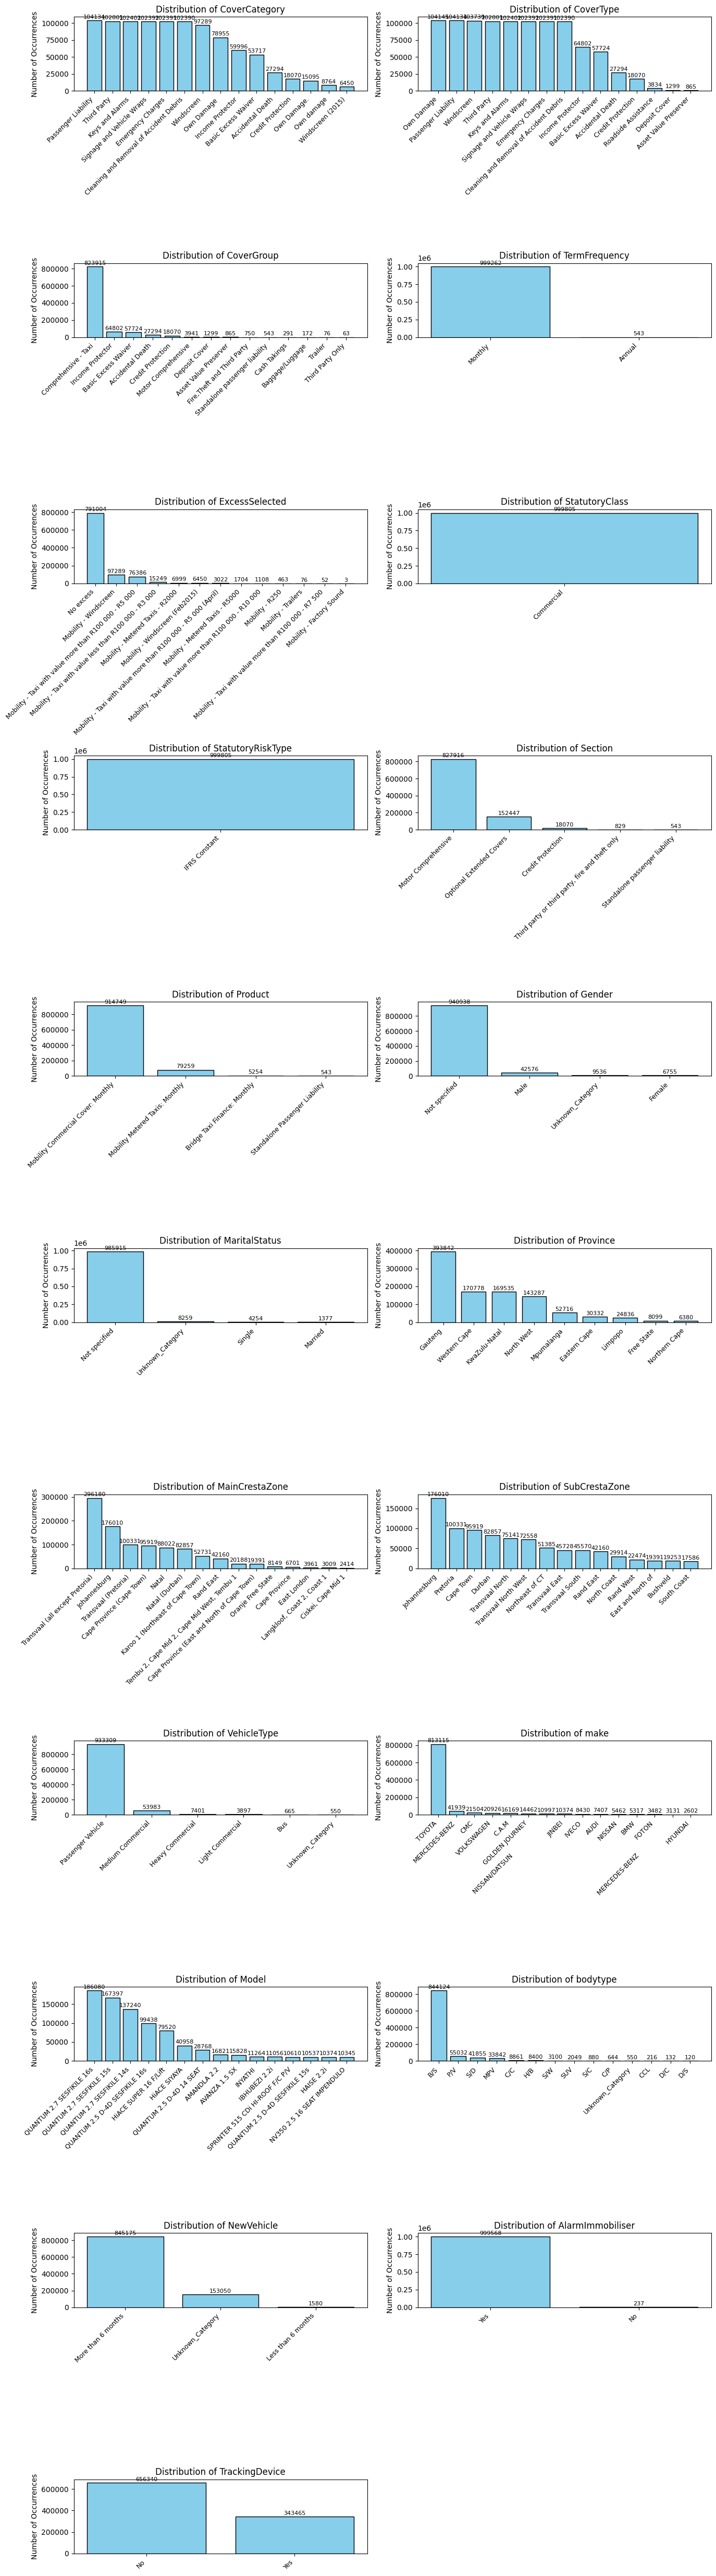

In [13]:
n_cols = 2
n_rows = math.ceil(len(categorical_cols) / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 7, n_rows * 4.5))
axes = axes.flatten()  # Flatten for easy indexing

for i, col in enumerate(categorical_cols):
    if col in df.columns:
        top_counts = df[col].value_counts().iloc[:15]  # Top 15 categories
        ax = axes[i]
        
        ax.bar(top_counts.index.astype(str), top_counts.values, color='skyblue', edgecolor='black')
        ax.set_title(f'Distribution of {col}', fontsize=12)
        ax.set_ylabel('Number of Occurrences', fontsize=10)
        ax.set_xticks(range(len(top_counts)))
        ax.set_xticklabels(top_counts.index, rotation=45, ha='right', fontsize=9)
        ax.set_xlabel('')

        # Add count labels on top of bars
        for j, val in enumerate(top_counts.values):
            ax.text(j, val + max(top_counts.values) * 0.01, str(val), ha='center', va='bottom', fontsize=8)
    else:
        print(f"Warning: Column '{col}' not found in DataFrame. Skipping.")

# Hide any unused subplots
for j in range(len(categorical_cols), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

For quantitative variables 

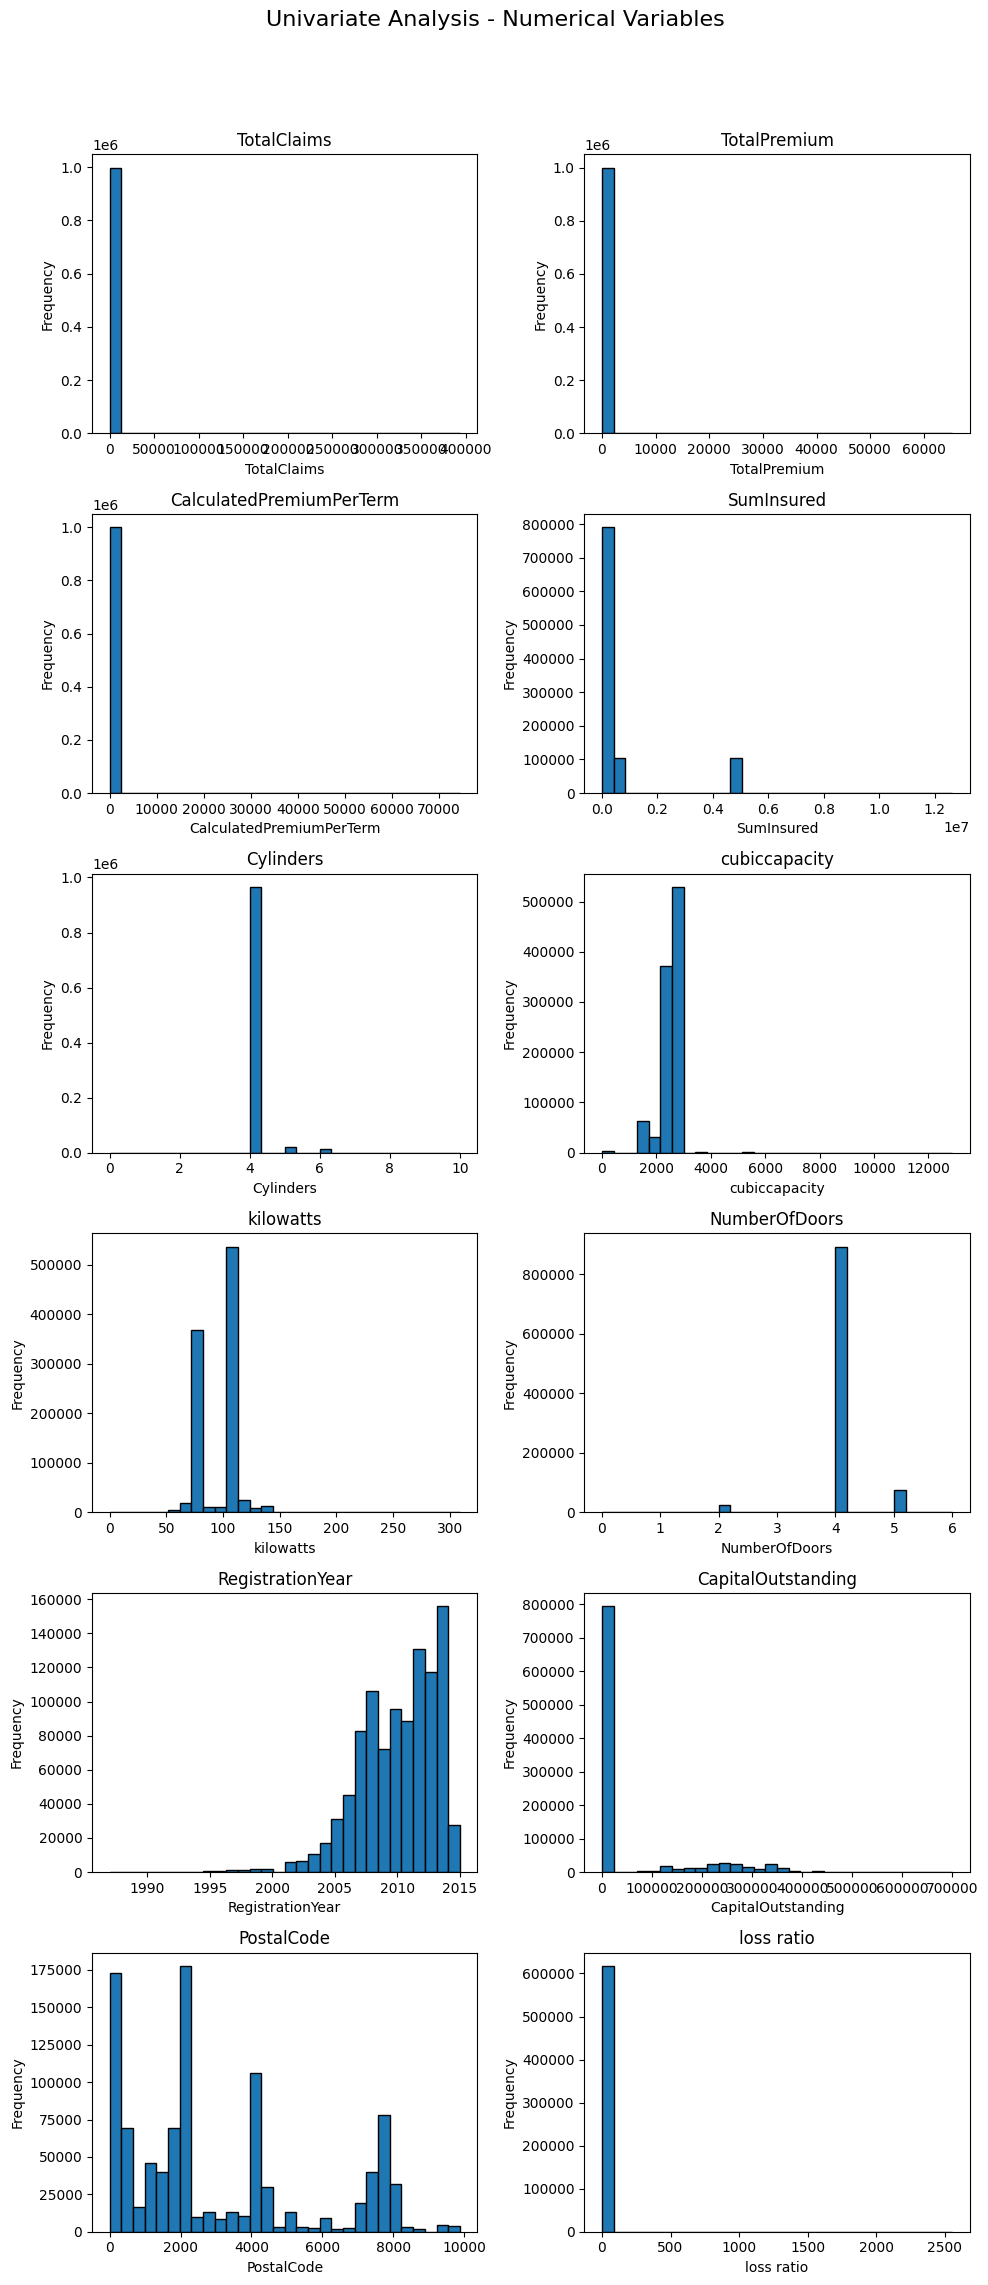

In [14]:
num_plots = len(numerical_cols)
cols = 2
rows = math.ceil(num_plots / cols)

fig, axes = plt.subplots(rows, cols, figsize=(cols*5, rows*4))
fig.suptitle('Univariate Analysis - Numerical Variables', fontsize=16)

for i, col in enumerate(numerical_cols):
    r, c = divmod(i, cols)
    ax = axes[r, c] if rows > 1 else axes[c]  # Handle when rows=1

    ax.hist(df[col].dropna(), bins=30, edgecolor='black')  # matplotlib hist
    ax.set_title(col)
    ax.set_xlabel(col)
    ax.set_ylabel('Frequency')

# Remove unused subplots
for i in range(num_plots, rows * cols):
    fig.delaxes(axes.flatten()[i])

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

Most policies/customers likely have 0 or very low TotalClaims, TotalPremium, CalculatedPremiumPerTerm, SumInsured, CapitalOutstanding, and loss ratio.
There are a few outliers or high-value instances that pull the average up and create the long tail.

# Bivaraite analysis

In [24]:
monthly_data = df.groupby(
    [df['TransactionMonth'].dt.to_period('M'), 'PostalCode'])[['TotalPremium', 'TotalClaims']].sum().reset_index()

# Convert back to datetime for plotting
monthly_data['TransactionMonth'] = monthly_data['TransactionMonth'].dt.to_timestamp()

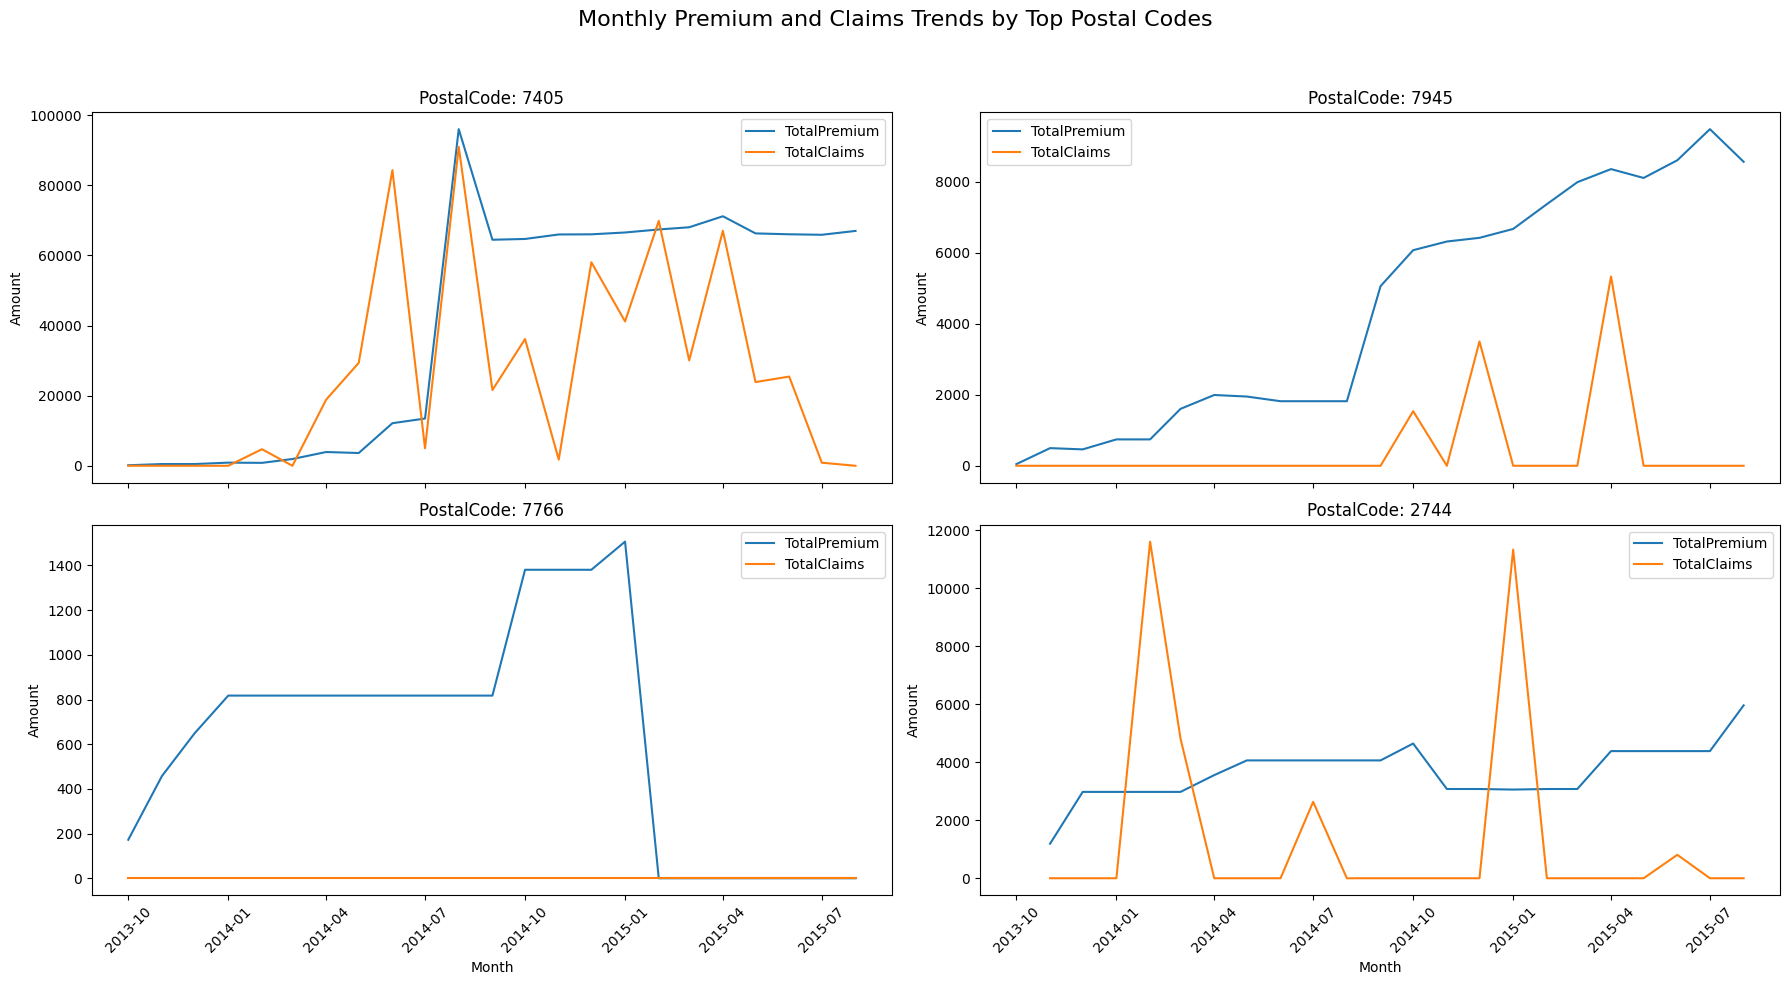

In [25]:
top_zipcodes = monthly_data['PostalCode'].value_counts().head(4).index

# Create a single figure with 4 subplots (1 row x 4 columns or 2x2 if preferred)
fig, axes = plt.subplots(2, 2, figsize=(18, 10), sharex=True, sharey=False)
axes = axes.flatten()  # Make it easier to iterate

for i, zip_code in enumerate(top_zipcodes):
    subset = monthly_data[monthly_data['PostalCode'] == zip_code]
    ax = axes[i]

    sns.lineplot(data=subset, x='TransactionMonth', y='TotalPremium', label='TotalPremium', ax=ax)
    sns.lineplot(data=subset, x='TransactionMonth', y='TotalClaims', label='TotalClaims', ax=ax)

    ax.set_title(f'PostalCode: {zip_code}')
    ax.tick_params(axis='x', rotation=45)
    ax.set_xlabel('Month')
    ax.set_ylabel('Amount')
    ax.legend()

# Remove unused subplot if fewer than 4 zip codes
for j in range(len(top_zipcodes), len(axes)):
    fig.delaxes(axes[j])

plt.suptitle('Monthly Premium and Claims Trends by Top Postal Codes', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


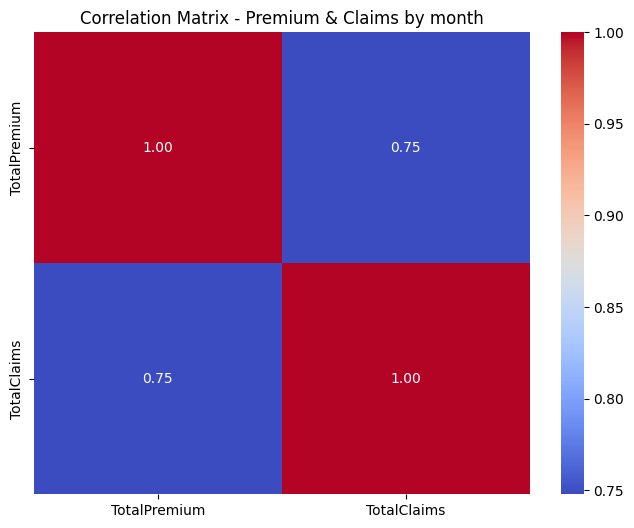

In [30]:
corr_matrix = monthly_data[['TotalPremium', 'TotalClaims']].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix - Premium & Claims by month')
plt.show()

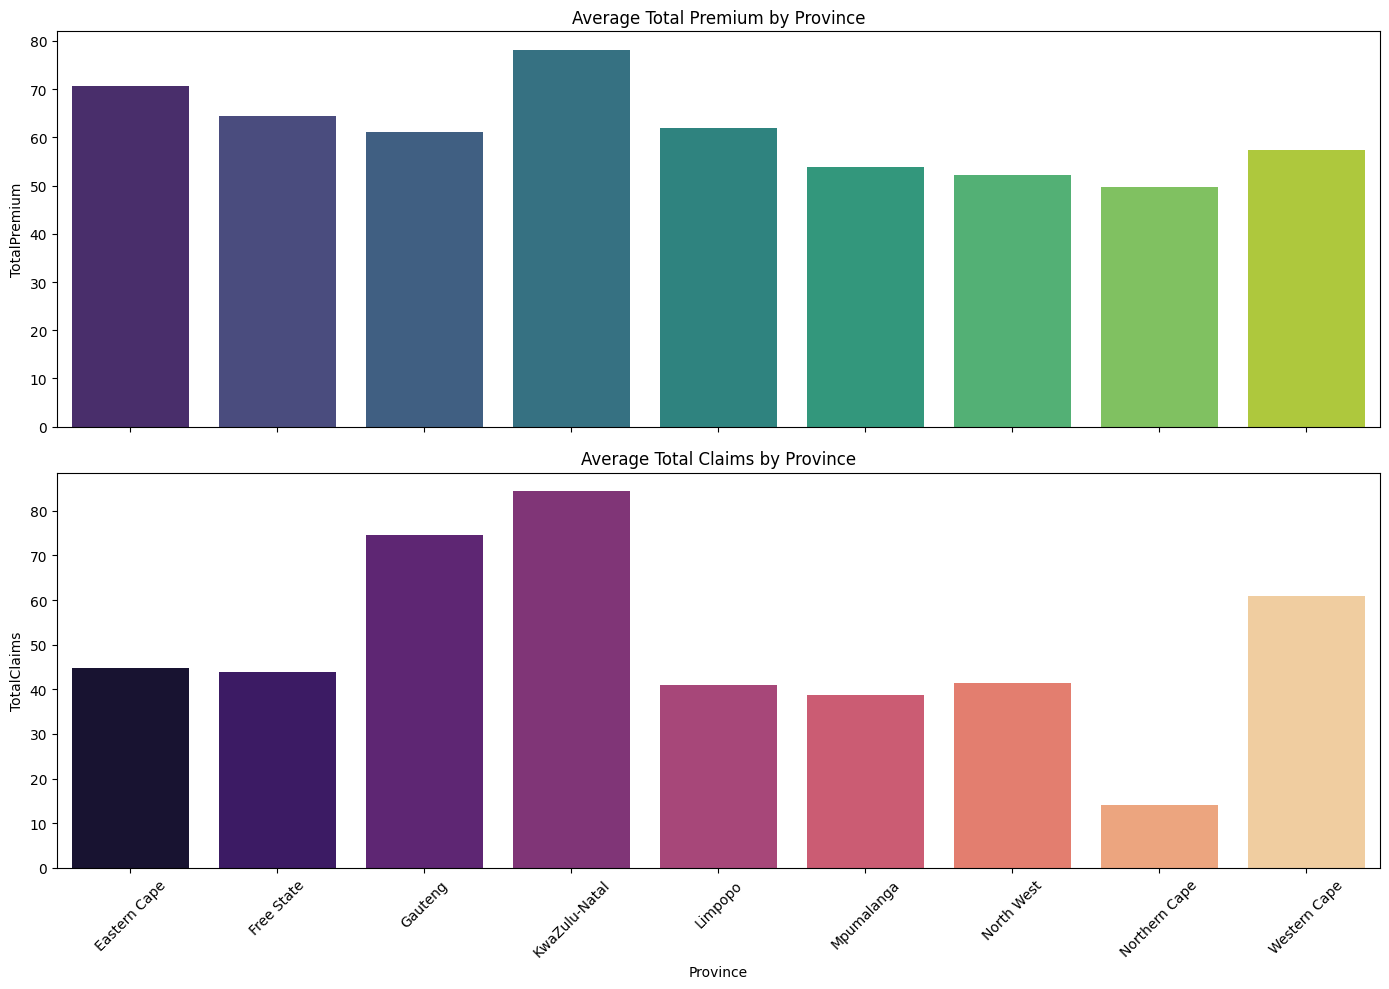

In [39]:
# Group by Province to get averages
avg_data = df.groupby('Province', observed=False)[['TotalPremium', 'TotalClaims']].mean().reset_index()

# Sort by TotalPremium for consistent order in both plots
avg_data = avg_data.sort_values(by='TotalPremium', ascending=False)

# Create subplots
fig, axes = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

# Plot TotalPremium
sns.barplot(data=avg_data, x='Province', y='TotalPremium',hue='Province', palette='viridis', ax=axes[0])
axes[0].set_title('Average Total Premium by Province')
axes[0].tick_params(axis='x', rotation=45)

# Plot TotalClaims
sns.barplot(data=avg_data, x='Province', y='TotalClaims',hue='Province', palette='magma', ax=axes[1])
axes[1].set_title('Average Total Claims by Province')
axes[1].set_xlabel('Province')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## Loss Ratio Distribution by Vehicle Type (Boxplot)
Insight: Identify vehicle types that have higher risk (loss ratio = claims/premium).

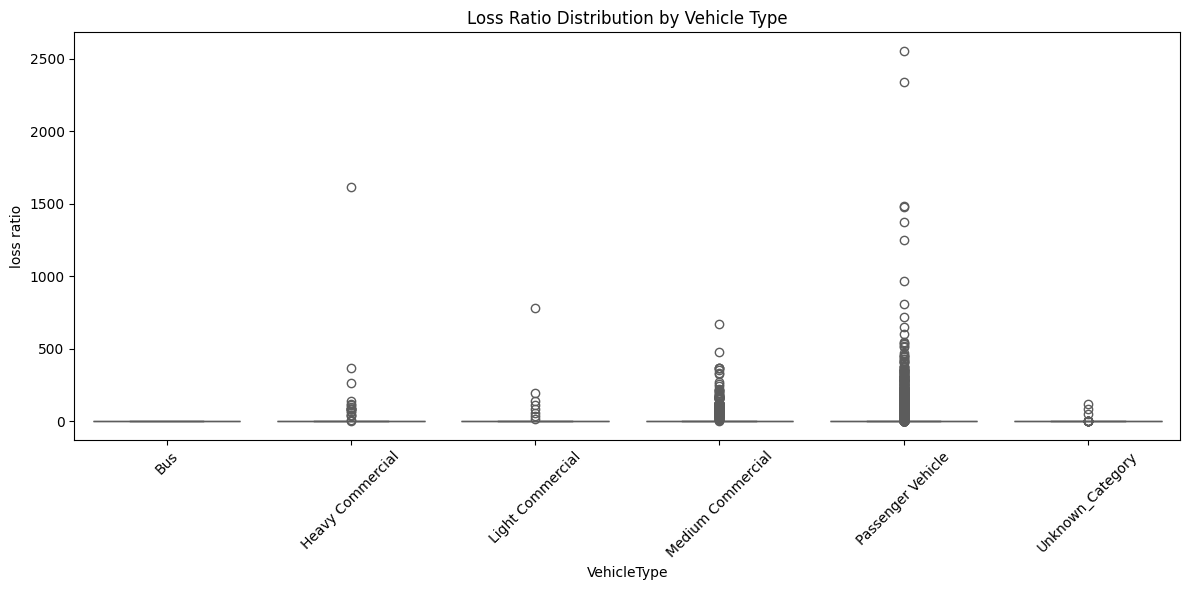

In [55]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='VehicleType', y='loss ratio', hue='VehicleType', palette='coolwarm', dodge=False, legend=False)
plt.title('Loss Ratio Distribution by Vehicle Type')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

- Passenger vehicles appear to be the most volatile in terms of loss ratio, exhibiting the widest range of values and the highest extreme outliers. This might suggest higher average repair costs, more frequent incidents, or a larger volume of policies contributing to these outliers.
- Commercial vehicles (Heavy, Light, Medium) also experience high loss ratio outliers, but generally to a lesser extent and with fewer occurrences than passenger vehicles.
- Buses consistently demonstrate the lowest loss ratios, suggesting they are a relatively low-risk category.

## Top Insurance Cover Types Across Provinces (Heatmap)
Insight: Understand which cover types are most common in each province.

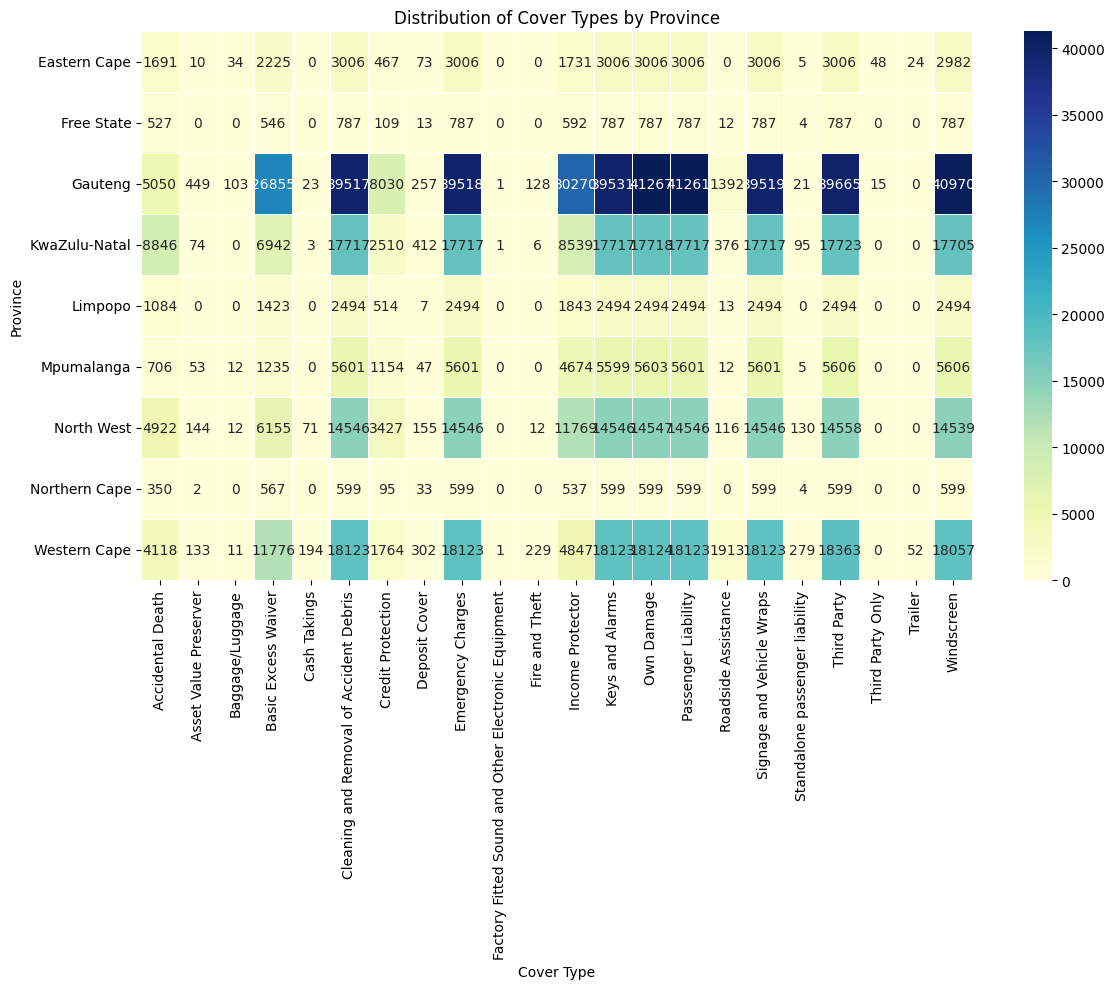

In [46]:
cover_pivot = df.pivot_table(index='Province', columns='CoverType', aggfunc='size', fill_value=0, observed=True)

plt.figure(figsize=(12, 10))
sns.heatmap(cover_pivot, cmap='YlGnBu', annot=True, fmt='d', linewidths=0.5)
plt.title('Distribution of Cover Types by Province')
plt.xlabel('Cover Type')
plt.ylabel('Province')
plt.tight_layout()
plt.show()

- **Gauteng** consistently has the highest number of covers across almost all cover types, indicated by the dark blue cells in its row. This is expected as Gauteng is the most populous and economically active province in South Africa.
- **KwaZulu-Natal** also shows a significant number of covers, though generally less than Gauteng.
- "Third Party Only" and "Passenger Liability" appear to be very popular cover types across multiple provinces, especially in Gauteng and KwaZulu-Natal, indicated by their dark blue shades.
- "Accidental Death" and "Asset Value Preserver" seem to have a relatively low number of covers across most provinces, often showing negative numbers in the plot. 

## Monthly Premium vs Claims Trend (Line Plot)
Insight: Understand seasonal or monthly fluctuations in premium collected and claims made

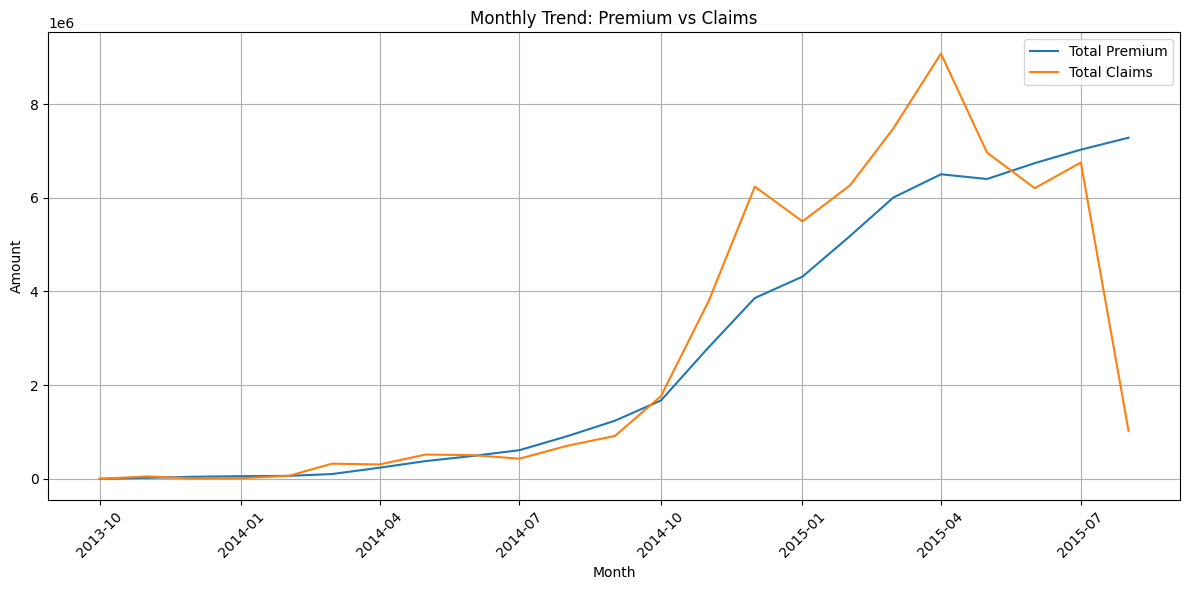

In [48]:
monthly_trend = df.groupby('TransactionMonth')[['TotalPremium', 'TotalClaims']].sum().reset_index()

plt.figure(figsize=(12, 6))
plt.plot(monthly_trend['TransactionMonth'], monthly_trend['TotalPremium'], label='Total Premium')
plt.plot(monthly_trend['TransactionMonth'], monthly_trend['TotalClaims'], label='Total Claims')
plt.title('Monthly Trend: Premium vs Claims')
plt.xlabel('Month')
plt.ylabel('Amount')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

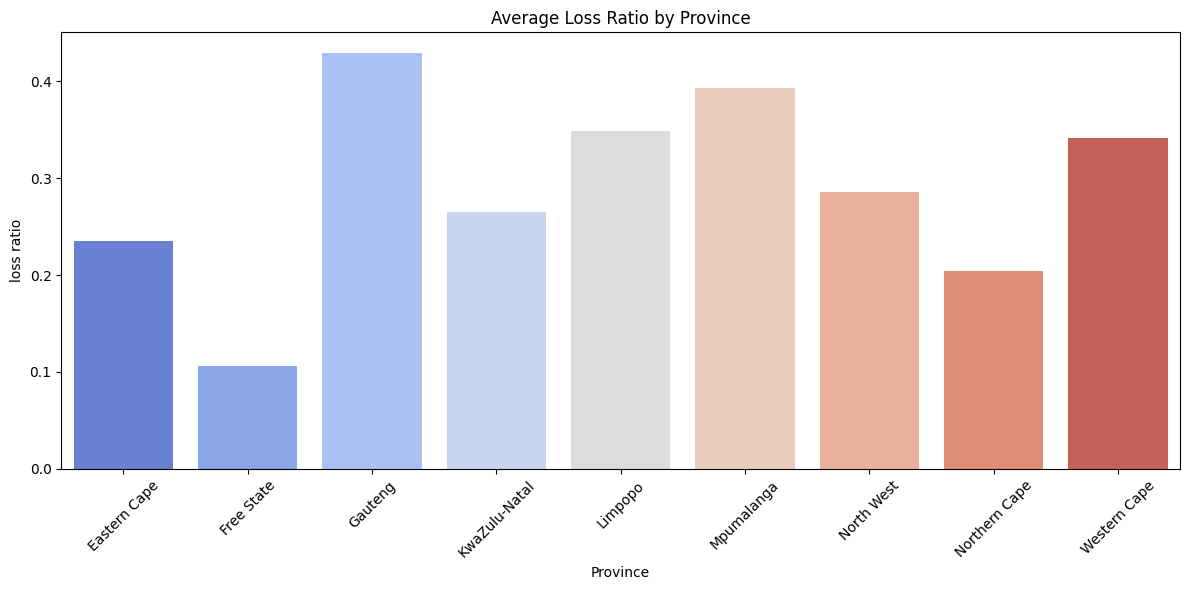

In [53]:
avg_loss = df.groupby('Province', observed=False)['loss ratio'].mean().reset_index()

plt.figure(figsize=(12,6))
sns.barplot(data=avg_loss, x='Province', y='loss ratio', hue='Province', palette='coolwarm', legend=False)
plt.title('Average Loss Ratio by Province')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Correlation Heatmap of Numerical Variables
Insight: Show relationships between features like Premium, Claims, SumInsured, etc.

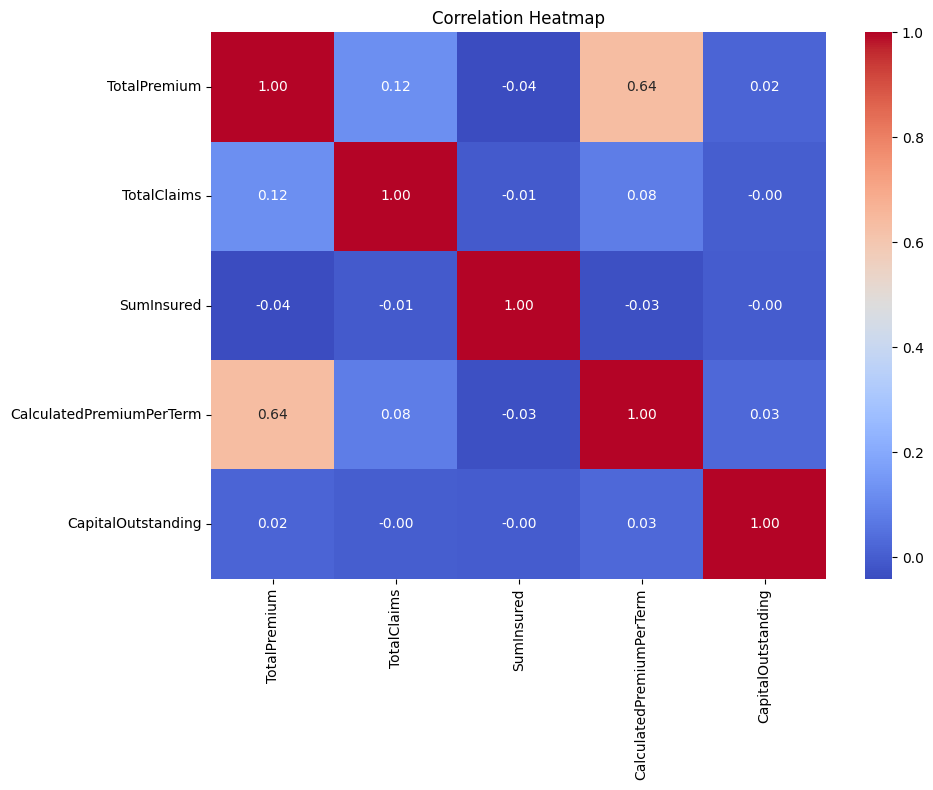

In [57]:
plt.figure(figsize=(10, 8))
numerical_cols = ['TotalPremium', 'TotalClaims', 'SumInsured', 'CalculatedPremiumPerTerm', 'CapitalOutstanding']
corr = df[numerical_cols].corr()

sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.tight_layout()
plt.show()

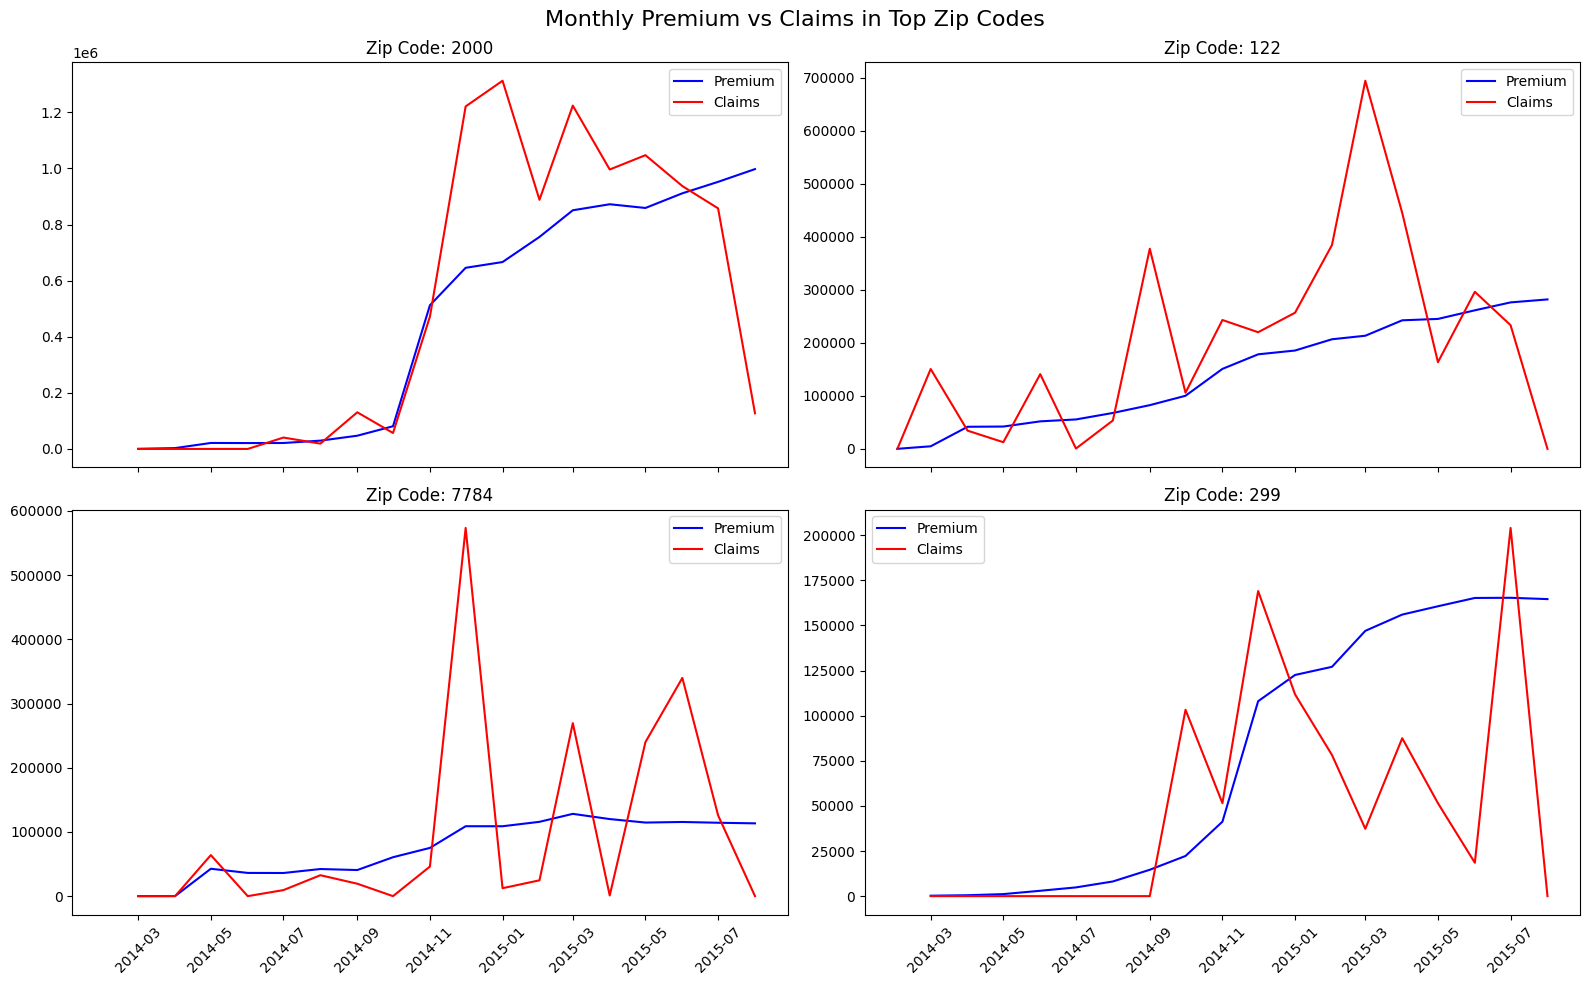

In [58]:
top_zipcodes = df['PostalCode'].value_counts().head(4).index
fig, axes = plt.subplots(2, 2, figsize=(16, 10), sharex=True)

for i, zip_code in enumerate(top_zipcodes):
    row, col = divmod(i, 2)
    subset = df[df['PostalCode'] == zip_code].groupby('TransactionMonth')[['TotalPremium', 'TotalClaims']].sum().reset_index()
    axes[row, col].plot(subset['TransactionMonth'], subset['TotalPremium'], label='Premium', color='blue')
    axes[row, col].plot(subset['TransactionMonth'], subset['TotalClaims'], label='Claims', color='red')
    axes[row, col].set_title(f"Zip Code: {zip_code}")
    axes[row, col].legend()
    axes[row, col].tick_params(axis='x', rotation=45)

plt.suptitle('Monthly Premium vs Claims in Top Zip Codes', fontsize=16)
plt.tight_layout()
plt.show()